# CSCI 453 "Please Compile" Final Project

### Logan Zug, Ben Albright, Gavin Fry

In [107]:
# Start with all of the includes we'll need for the project...

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [109]:
# Begin...

In [110]:
df = pd.read_csv("reviews.csv")

In [111]:
df.drop(['unix_timestamp_created', 'unix_timestamp_updated'], axis=1, inplace=True)
df.dropna(inplace=True)

In [112]:
df.rename(columns={'weighted_vote_score': 'helpful_score', 'voted_up': 'is_recommended', 'votes_up': 'upvotes'}, inplace=True)

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1452657 entries, 0 to 1455441
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   steamid             1452657 non-null  int64  
 1   appid               1452657 non-null  int64  
 2   is_recommended      1452657 non-null  bool   
 3   upvotes             1452657 non-null  int64  
 4   votes_funny         1452657 non-null  int64  
 5   helpful_score       1452657 non-null  float64
 6   playtime_forever    1452657 non-null  int64  
 7   playtime_at_review  1452657 non-null  int64  
 8   num_games_owned     1452657 non-null  int64  
 9   num_reviews         1452657 non-null  int64  
 10  review              1452657 non-null  object 
dtypes: bool(1), float64(1), int64(8), object(1)
memory usage: 123.3+ MB


# Gavin

## Feature-Scaling (Playtime After Negative Review)

In [114]:
# Determine the lower and upper range for 'playtime_forever'
q_low = df["playtime_forever"].quantile(0.05)
q_high  = df["playtime_forever"].quantile(0.95)

# Take the previously determined lower and upper and use them to filter the data
df = df[(df["playtime_forever"] < q_high) & (df["playtime_forever"] > q_low)]

# Determine the lower and upper range for 'playtime_at_review'
q_low = df["playtime_at_review"].quantile(0.05)
q_high  = df["playtime_at_review"].quantile(0.95)

# Take the previously determined lower and upper and use them to filter the data
df = df[(df["playtime_at_review"] < q_high) & (df["playtime_at_review"] > q_low)]

# Make a mask for all rows within df that have recommended = false
mask = df[(df['is_recommended']==False)]

# Take one sample of 10k users for statistics, another of 50 users for the graph.
dataStatistics = mask.sample(n=10000, random_state = 0, replace = False)
dataGraph = mask.sample(n=50, random_state = 0, replace = False)

# Establish a new column, 'playtime_after_review' that takes the difference of playtime forever and at review.
dataGraph['playtime_after_review'] = dataGraph['playtime_forever'] - dataGraph['playtime_at_review']
dataStatistics['playtime_after_review'] = dataStatistics['playtime_forever'] - dataStatistics['playtime_at_review']

# Sort the dataframe by 'playtime after review'
dataGraph = dataGraph.sort_values(by="playtime_at_review", ascending = True)

In [115]:
# Describing the sample we took...
dataStatistics.playtime_after_review.describe()

count    10000.000000
mean       711.620200
std       1870.668175
min         -2.000000
25%          0.000000
50%         21.000000
75%        441.000000
max      17021.000000
Name: playtime_after_review, dtype: float64

In [116]:
# Initialize scaler
scaler = MinMaxScaler()

# To scale playtime_after_review
scaler.fit(dataGraph['playtime_after_review'].values.reshape(-1,1)) 

# Fit the new scaled data into the dataframe
dataGraph['playtime_after_review']=scaler.transform(dataGraph['playtime_after_review'].values.reshape(-1,1))

# To scale playtime_after_review
scaler.fit(dataGraph['playtime_at_review'].values.reshape(-1,1)) 

# Fit the new scaled data into the dataframe
dataGraph['playtime_at_review_scaled']=scaler.transform(dataGraph['playtime_at_review'].values.reshape(-1,1))

# Instantiate the Label Encoder Object
label_encoder = LabelEncoder()

# Fit and transform the column into new column 'individual' to keep track of users sequentally instead of as an id
dataGraph['Individual'] = label_encoder.fit_transform(dataGraph['steamid'])

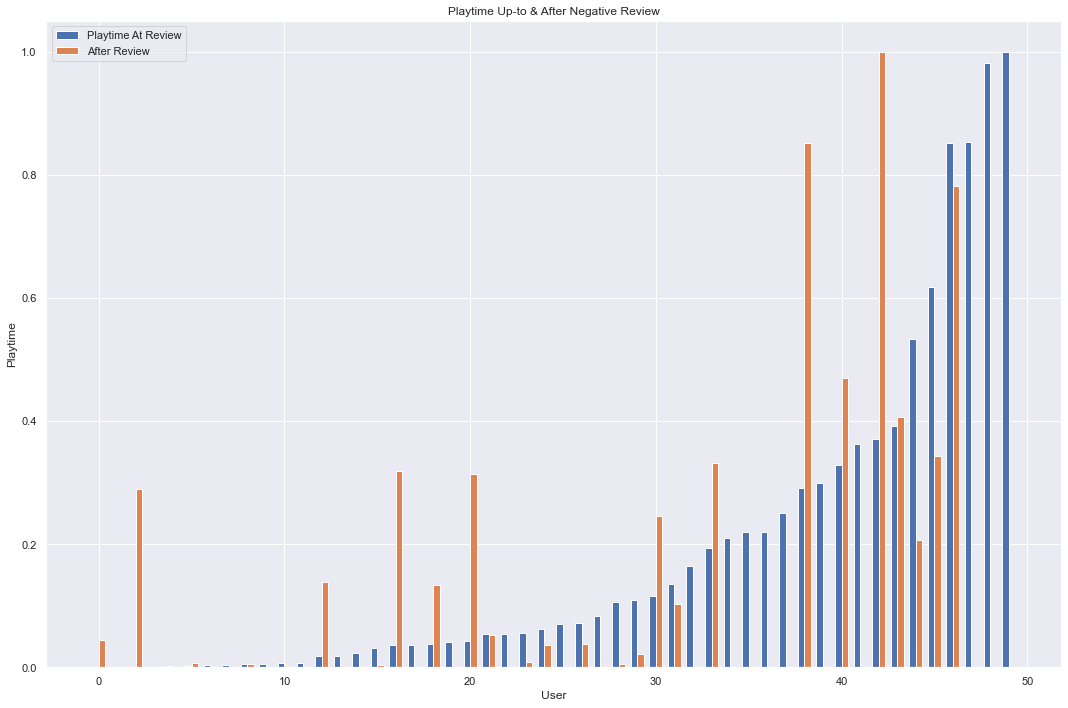

In [117]:
# Set the labels to be each individual within the sample
labels = dataGraph.Individual

# the label locations
x = np.arange(len(labels))
# the width of the bars
width = 0.35  

# Prepare the figure for sublots, since it will be a paired bar graph
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, dataGraph.playtime_at_review_scaled, width, label='Playtime At Review')
rects2 = ax.bar(x + width/2, dataGraph.playtime_after_review, width, label='After Review')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Playtime')
ax.set_xlabel('User')
ax.set_title('Playtime Up-to & After Negative Review')
ax.legend()

# Set the layout and size for the figure.
fig.tight_layout()
fig.set_size_inches(15,10)

# Show the plot
plt.show()

In [118]:
# In the above graph, you can see that on average, users who reviewed negatively played less time after the review than before.
# This is to be expected, since if an individual does not like a game, they probably won't come back to play it in the future.
# There is a minor subset of individuals that played the game for a short amount of time, reviewed it negatively, then continued
# to play it for a significant amount of time.  This could be explained by a few things.  First, I believe individuals could
# have left the review as a joke, saying "wasn't that great" then having thousands of hours somewhat ironically.  Next, I 
# believe this could be explained by individuals reviewing a game negatively, then returning to play the game once it has had
# significant fixes without updating there previous review.

## Clustering (Helpfulness vs Funniness)

In [119]:
# Take the two columns we want from OG df...
df2 = df[["votes_funny", "helpful_score"]]

# Drop significantly low values
df2= df2[df2.votes_funny > 2]
df2= df2[df2.helpful_score > 0.7]

# Feature transformation to correct left-skew
df2['votes_funny'] = df2['votes_funny']
df2['helpful_score'] = df2['helpful_score']

In [120]:
# Take a sample of 5000 reviews with a random seed 1...
data = df2.sample(n=5000, random_state = 1, replace = False)

# Determine the lower and upper range for votes_funny
q_lowFunny = data["votes_funny"].quantile(0.05)
q_hiFunny  = data["votes_funny"].quantile(0.90)

# Determine the lower and upper range for helpful....
q_lowHelpful = data["helpful_score"].quantile(0.05)
q_hiHelpful  = data["helpful_score"].quantile(0.90)

# Take the previously determined lower and upper and use them to filter the data
df_filtered = data[(data["votes_funny"] < q_hiFunny) & (data["votes_funny"] > q_lowFunny)]
df_filtered = data[(data["helpful_score"] < q_hiHelpful) & (data["helpful_score"] > q_lowHelpful)]

# To scale votes_funny
scaler.fit(df_filtered['votes_funny'].values.reshape(-1,1)) 

# Fit the new scaled data into the dataframe
df_filtered['votes_funny']=scaler.transform(df_filtered['votes_funny'].values.reshape(-1,1))

# To scale helpful_score
scaler.fit(df_filtered['helpful_score'].values.reshape(-1,1)) 

# To scale helpful_score
scaler.fit(df_filtered['helpful_score'].values.reshape(-1,1)) 

# Fit the new scaled data into the dataframe
df_filtered['helpful_score']=scaler.transform(df_filtered['helpful_score'].values.reshape(-1,1))

# Feature transformation on helpful_score to help skew
df_filtered['helpful_score'] = df_filtered['helpful_score']**2

# Define number of clusters
num_clusters = 10
 
# Creating instance of PCA and transforming the data from df_filtered to fit PCA
pca = PCA()
data_pca = pca.fit_transform(df_filtered)

# Creating the PC columns within pca_df for use in clustering
pca_df = pd.DataFrame(data_pca,columns=['PC1','PC2'])

# Create and fit the KMeans model
km = KMeans(n_clusters=num_clusters)
km.fit(df_filtered)
 
# Predict the target variable
pred=km.predict(df_filtered)

/var/folders/qx/plbymthn3ll70xs0g_90_5rh0000gn/T/ipykernel_67171/1480363163.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['votes_funny']=scaler.transform(df_filtered['votes_funny'].values.reshape(-1,1))
/var/folders/qx/plbymthn3ll70xs0g_90_5rh0000gn/T/ipykernel_67171/1480363163.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['helpful_score']=scaler.transform(df_filtered['helpful_score'].values.reshape(-1,1))
/var/folders/qx/plbymthn3ll70xs0g_90_5rh0000gn/T/ipykernel_67171

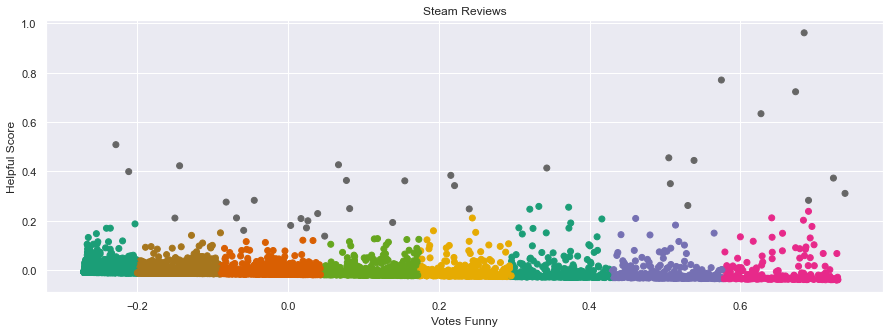

In [121]:
# Plot the Clusters
plt.figure(figsize=(15,5))
plt.scatter(pca_df.PC1, pca_df.PC2, c=pred, cmap = 'Dark2')
# Set title of the plot 
plt.title('Steam Reviews')
# Set x-axis label
plt.xlabel('Votes Funny')
# Set y-axis label
plt.ylabel('Helpful Score')
# Display the plot
plt.show()

In [122]:
# For this section, I created a scatter plot to represent the relation of "Votes Funny" vs "Helpful Score".  In this scenario I
# also clustered based on the votes funny.  The ultimate result of this excercise was that there really wasn't much correlation
# between votes funny and helpful score.  What I did notice is that it seems like a few reviews were buried by some individuals
# that accrued quite a large sum of both helpful and funny votes.  The clustering can be used to identify that quite a large 
# portion of the data is within the lower end of the funny votes. In terms of helpful score, most items sat around an average
# helpful score of 0.

# Ben

## Agglomerative Clustering

In [123]:
#For this section, I started by using a second clustering method, agglomerative, so that I could compare the two algorigthms.
#Again, I clustered on Funny Votes and found little correlation as was the case with K-means.
#Then, different scoring algorithms were used to check the accuracy of the clustering algorithms.

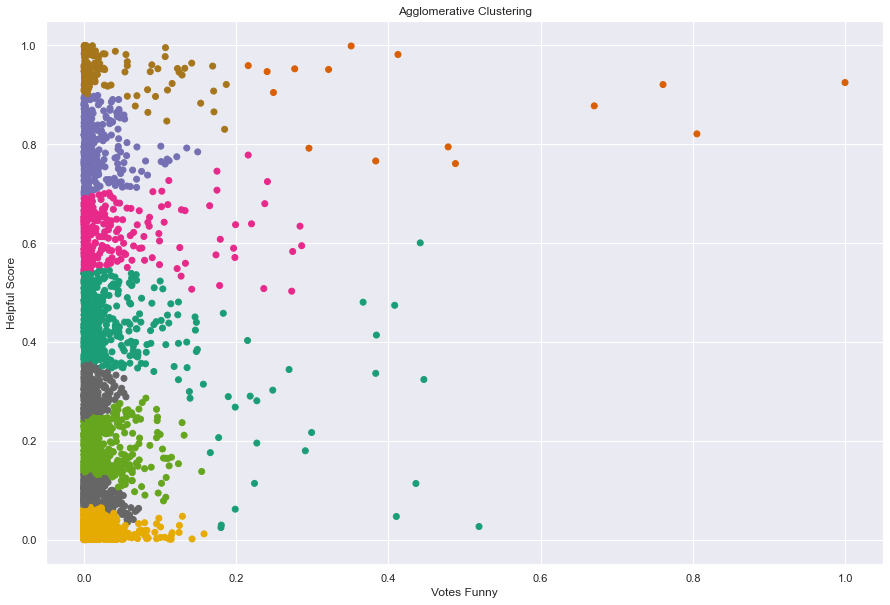

In [124]:
# Using the same dataset as Gavin used above, so that we can compare the performance of the two clustering algorithms
df_filtered

# Specify number of clusters
num_clusters = 10
 
# Create agglomerative clustering model
ac = AgglomerativeClustering(n_clusters = num_clusters, linkage='ward')
 
# Fit the Agglomerative Clustering model
ac.fit(df_filtered)
 
# Predict the target variable
pred_ac=ac.labels_

# Plot the Cluster
plt.scatter(df_filtered.votes_funny,df_filtered.helpful_score, c=pred_ac, marker="o", cmap = 'Dark2')

# Set title of the plot 
plt.title('Agglomerative Clustering')
# Set x-axis label
plt.xlabel('Votes Funny')
# Set y-axis label
plt.ylabel('Helpful Score')
# Display the plot
plt.show()

In [125]:
clustering_df = pd.DataFrame({'labels': pred_ac, 'helpful score': df_filtered.helpful_score})
clustering_df

,labels,helpful score
1258031,5,0.143443
698571,5,0.236265
1436209,6,0.052239
1427705,9,0.293210
839905,0,0.426330
...,...,...
1034276,4,0.586337
356362,6,0.000068
989919,8,0.091318
430960,6,0.028772


In [126]:
print('k-means inertia')
print(km.inertia_)

k-means inertia
8.97753403299517


In [127]:
from sklearn.model_selection import train_test_split
feature_train, feature_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=1)

In [128]:
#K Means Clustering Performance

# Specify the number of clusters
num_clusters = 10
 
# Create and fit the KMeans model
km = KMeans(n_clusters=num_clusters)
km.fit(feature_train)
 
# Predict the target variable
predictions=km.predict(feature_test)
 
# Calculate internal performance evaluation measures
print("Davies-Bouldin Index:", davies_bouldin_score(feature_test, predictions))
print("Silhouette Coefficient:", silhouette_score(feature_test, predictions))

# Calculate External performance evaluation measures
print("Adjusted Rand Score:", adjusted_rand_score(target_test, predictions))
print("Fowlkes Mallows Score:", fowlkes_mallows_score(target_test, predictions))

Davies-Bouldin Index: 0.437008466450841
Silhouette Coefficient: 0.7551418413179551
Adjusted Rand Score: 0.005530535622403023
Fowlkes Mallows Score: 0.08254420971077892


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


In [129]:
# Agglomerative Clustering Performance

# Specify the number of clusters
num_clusters = 10
 
# Create and fit the KMeans model
ac = AgglomerativeClustering(n_clusters = num_clusters, linkage='ward')
ac.fit(feature_train)
 
# Predict the target variable
pred_ac=ac.labels_
 
# Calculate internal performance evaluation measures
print("Davies-Bouldin Index:", davies_bouldin_score(feature_test, predictions))
print("Silhouette Coefficient:", silhouette_score(feature_test, predictions))

# Calculate External performance evaluation measures
print("Adjusted Rand Score:", adjusted_rand_score(target_test, predictions))
print("Fowlkes Mallows Score:", fowlkes_mallows_score(target_test, predictions))

Davies-Bouldin Index: 0.437008466450841
Silhouette Coefficient: 0.7551418413179551
Adjusted Rand Score: 0.005530535622403023
Fowlkes Mallows Score: 0.08254420971077892


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


## Graphs

In [130]:
#Next, I created a few plots to display and analyze the data.
#I began by filtering the data and creating samples, as our dataset was much too large and had outliers to begin with.
#I plotted the Playtime vs Recommendation on a Violin plot, showing whether they recommend the game and how many hours they had upon review.
#I plotted the number of games owned vs helpfulness of the review on a jointgrid, which gives a good glimpse at the volume of datapoints at each side of the graph.
#Lastly I plotted the total number of reviews vs helpfulness of the review on a scatter plot to get an idea of whether or not peoples' reviews became more helpful after having written other reviews in the past.

### Filtering and Sampling data for graphs

In [131]:
# Take the two columns we want from OG df...
df3 = df[["playtime_at_review", "is_recommended", "num_games_owned", "num_reviews", "helpful_score"]]

# Drop 0's
df3= df3[df3['helpful_score'] != 0]

# Determine the lower and upper range for helpful....
q_lowHelpful = df3["helpful_score"].quantile(0.05)
q_hiHelpful  = df3["helpful_score"].quantile(0.95)

#q_lowReview = df3["num_reviews"].quantile(0.05)
q_hiReview = df3["num_reviews"].quantile(0.95)

q_lowTime = df3["playtime_at_review"].quantile(0.05)
q_hiTime = df3["playtime_at_review"].quantile(0.95)

# Take the previously determined lower and upper and use them to filter the data
df_filtered = df3[(df3["helpful_score"] < q_hiHelpful) & (df3["helpful_score"] > q_lowHelpful)]
df_filtered = df_filtered[(df_filtered["num_reviews"] < q_hiReview)]
df_filtered = df_filtered[(df_filtered["playtime_at_review"] < q_hiTime) & (df_filtered["playtime_at_review"] > q_lowTime)]
df_filtered = df_filtered[(df_filtered["num_games_owned"] < 2500) & (df_filtered["num_games_owned"] > 10)]


# Take a sample of 5000 reviews with a random seed 1...
df_filtered = df_filtered.sample(n=5000, random_state = 1, replace = False)

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 1205889 to 1320385
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   playtime_at_review  5000 non-null   int64  
 1   is_recommended      5000 non-null   bool   
 2   num_games_owned     5000 non-null   int64  
 3   num_reviews         5000 non-null   int64  
 4   helpful_score       5000 non-null   float64
dtypes: bool(1), float64(1), int64(3)
memory usage: 200.2 KB


In [132]:
#Setting a consistent size for the figures below
sns.set(rc={'figure.figsize':(15,10)})

### Playtime x isRecommended

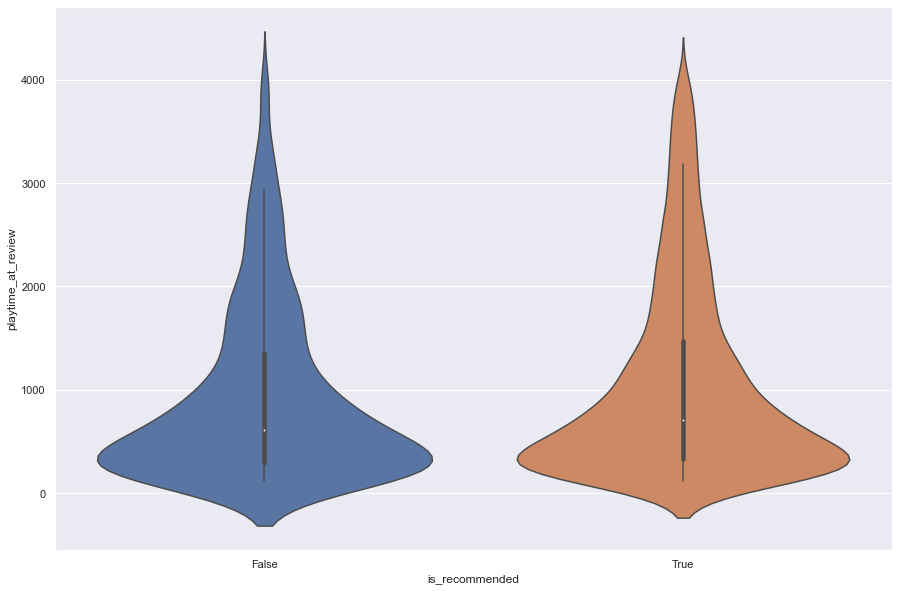

In [133]:
#use a stripplot with true/false on the y-axis and all of the playtimes plotted on x-axis
fig = sns.violinplot(x="is_recommended", y="playtime_at_review", data=df_filtered)

#df_filtered.head()

### num games owned x helpfulness of review

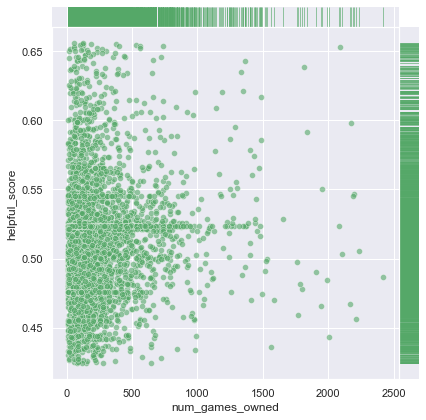

In [134]:
g = sns.JointGrid(data=df_filtered, x="num_games_owned", y="helpful_score", space=0, ratio=17)
g.plot_joint(sns.scatterplot, color="g", alpha=.6, legend=False)
g.plot_marginals(sns.rugplot, height=1, color="g", alpha=.6)

### num reviews x helpfulness of review

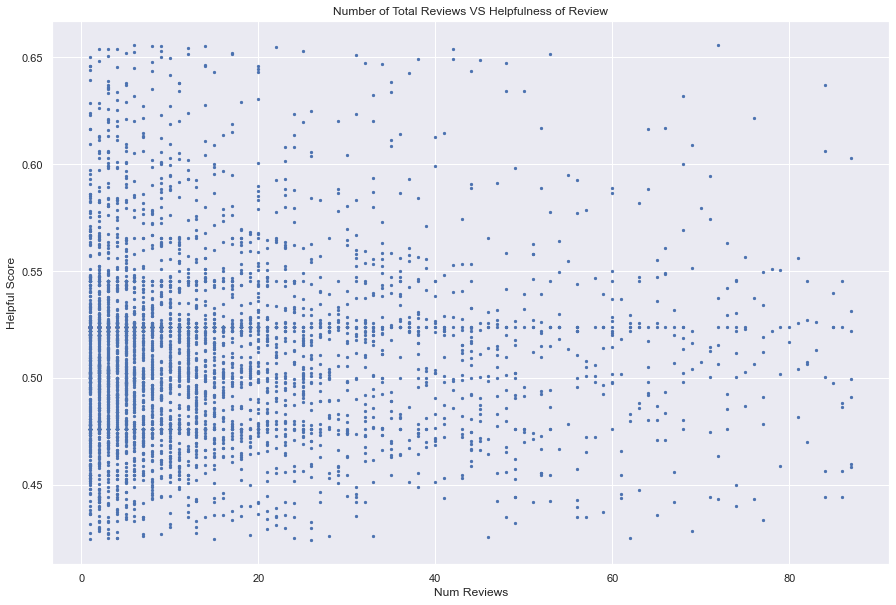

In [135]:
plt.scatter(df_filtered.num_reviews, df_filtered.helpful_score, s=5)
# Set title of the plot 
plt.title('Number of Total Reviews VS Helpfulness of Review')
# Set x-axis label
plt.xlabel('Num Reviews')
# Set y-axis label
plt.ylabel('Helpful Score')
# Display the plot
plt.show()

# Logan


[Text(0.5, 0, 'Characters in Review'),
 Text(0, 0.5, 'Average Number of Games Owned')]

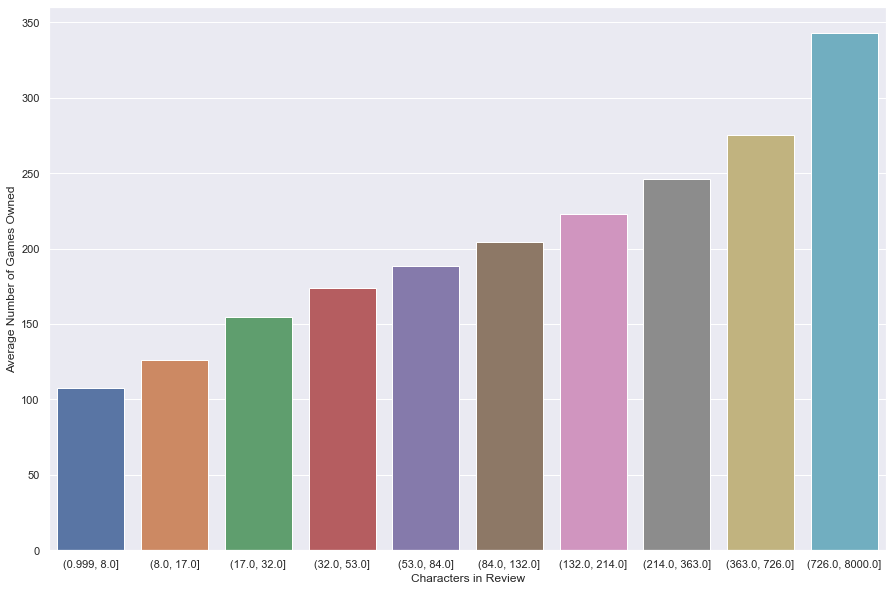

In [136]:
#Bar graphs using review character counts

#getting rid of large funny vote outliers 
df = df[df['votes_funny'] < 4294967292]

#cut into equal sized bins based on character length of review then get mean by grouping on bin
data = df.groupby(pd.qcut(df.review.map(lambda x: len(x)), q=10)).mean().reset_index()

#review length of review to number of games owned
sns.set(rc={'figure.figsize':(15,10)})
fig = sns.barplot(x='review', y='num_games_owned', data=data)
fig.set(xlabel='Characters in Review', ylabel="Average Number of Games Owned")

[Text(0.5, 0, 'Characters in Review'), Text(0, 0.5, 'Average Helpful Score')]

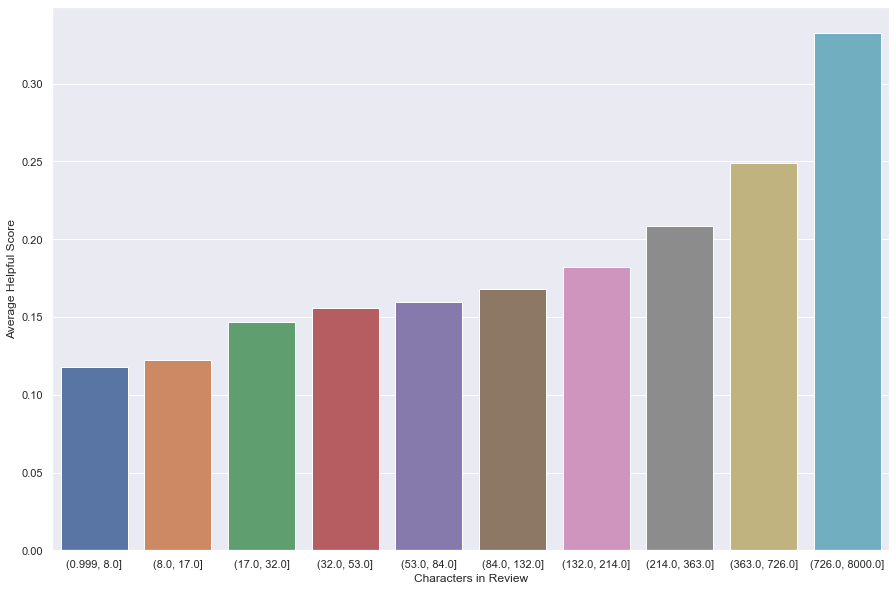

In [137]:
#review length to helpful score
sns.set(rc={'figure.figsize':(15,10)})
fig = sns.barplot(x='review', y='helpful_score', data=data)
fig.set(xlabel='Characters in Review', ylabel="Average Helpful Score")

[Text(0.5, 0, 'Characters in Review'), Text(0, 0.5, 'Average Funny Votes')]

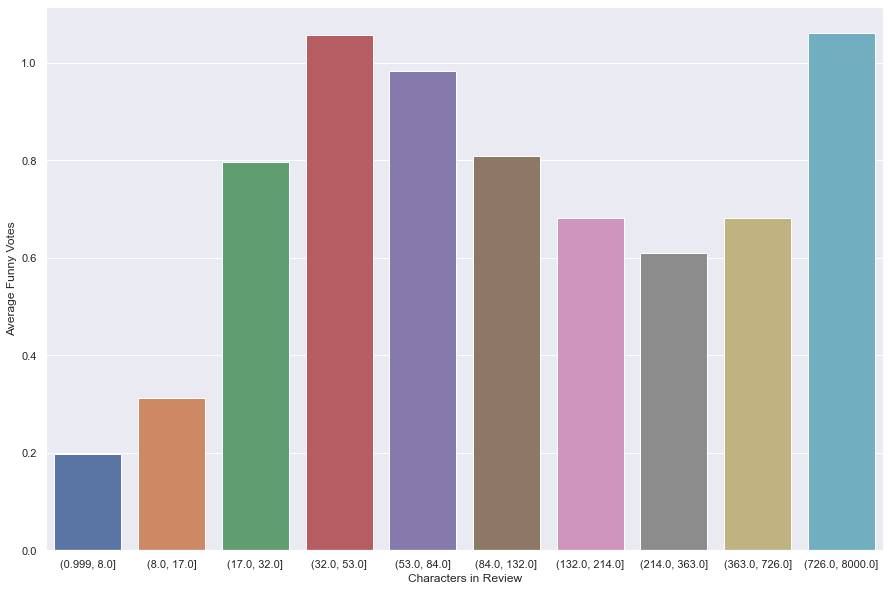

In [138]:
#review lengh to funny votes
sns.set(rc={'figure.figsize':(15,10)})
fig = sns.barplot(x='review', y='votes_funny', data=data)
fig.set(xlabel='Characters in Review', ylabel="Average Funny Votes")

(0.0, 50000.0)

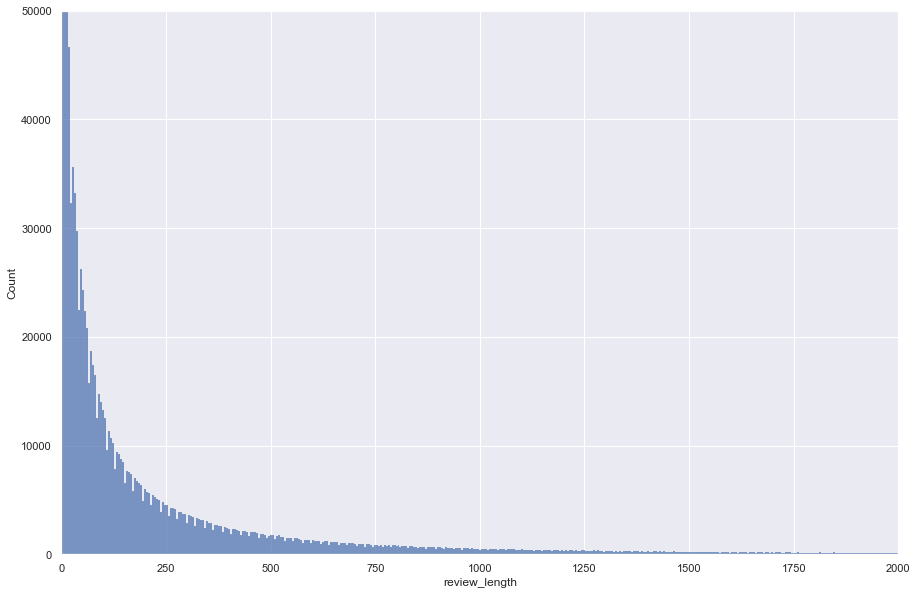

In [139]:
#histagram of review character lengths
df["review_length"] = df.review.map(lambda x: len(x))
sns.histplot(x='review_length', data=df)
plt.xlim(0,2000)
plt.ylim(0,50000)

In [140]:
#word count
import re

#returns the count for the specified portion of reviews
def get_counts(reviews):
    word_count = {}
    for review in reviews:
        words = review.split()
        for word in words:
            word = re.sub('[^a-zA-Z]+', '', word)
            word = word.lower()
            if word in word_count:
                word_count[word] = word_count[word] + 1
            else: 
                word_count[word] =  1
    word_count.pop('', None)
    return word_count

#this takes a while to run!
word_count_all = get_counts(df['review']) #all reviews words count
#split words to not recommended words and recommended words to do further analysis
word_count_r = get_counts( df[df['is_recommended'] == True]["review"]) #words for recommended
word_count_nr = get_counts(df[df['is_recommended'] == False]["review"]) #words for not recommended
print("done")

done


<BarContainer object of 20 artists>

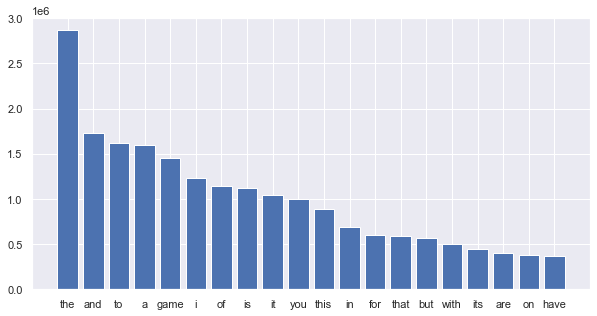

In [141]:
#get the top words from all reviews
top_words = sorted(word_count_all.items(), key=lambda item: item[1], reverse=True)[:20]
word = list(zip(*top_words))[0]
count = list(zip(*top_words))[1]
plt.figure(figsize=(10,5))
plt.bar(word, count)

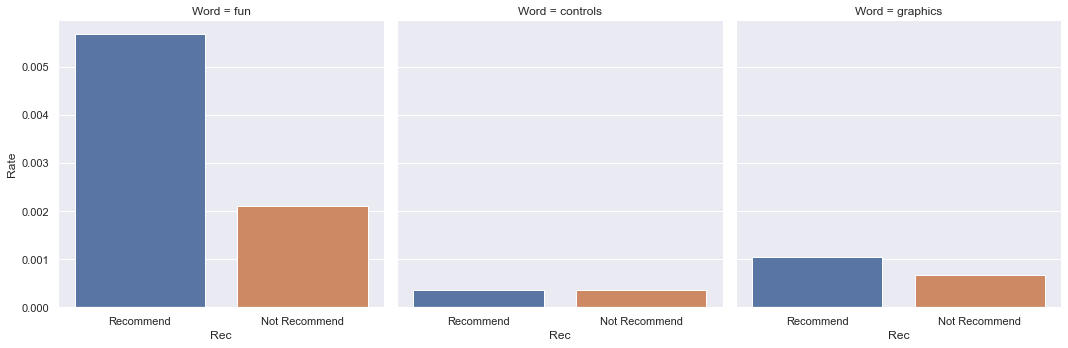

In [142]:
#compare words occurance rate between recommended and not recommended reviews

#pass in list of words and get not recommended and recommended rates for each word
def get_rates(words):
    word_rates = []
    for word in words:
        not_rec_rate = word_count_nr[word]/sum(word_count_nr.values())
        rec_rate = word_count_r[word]/sum(word_count_r.values())
        word_rates.append((word, "Recommend", rec_rate))
        word_rates.append((word, "Not Recommend", not_rec_rate))
    return word_rates 
#choose words to get values
rates = get_rates(["fun", "controls", "graphics"])
#create dataframe for catplot
rates_df = pd.DataFrame.from_records(rates, columns =['Word', 'Rec', 'Rate'])

sns.catplot(x="Rec", y="Rate", col="Word", data=rates_df, kind="bar")

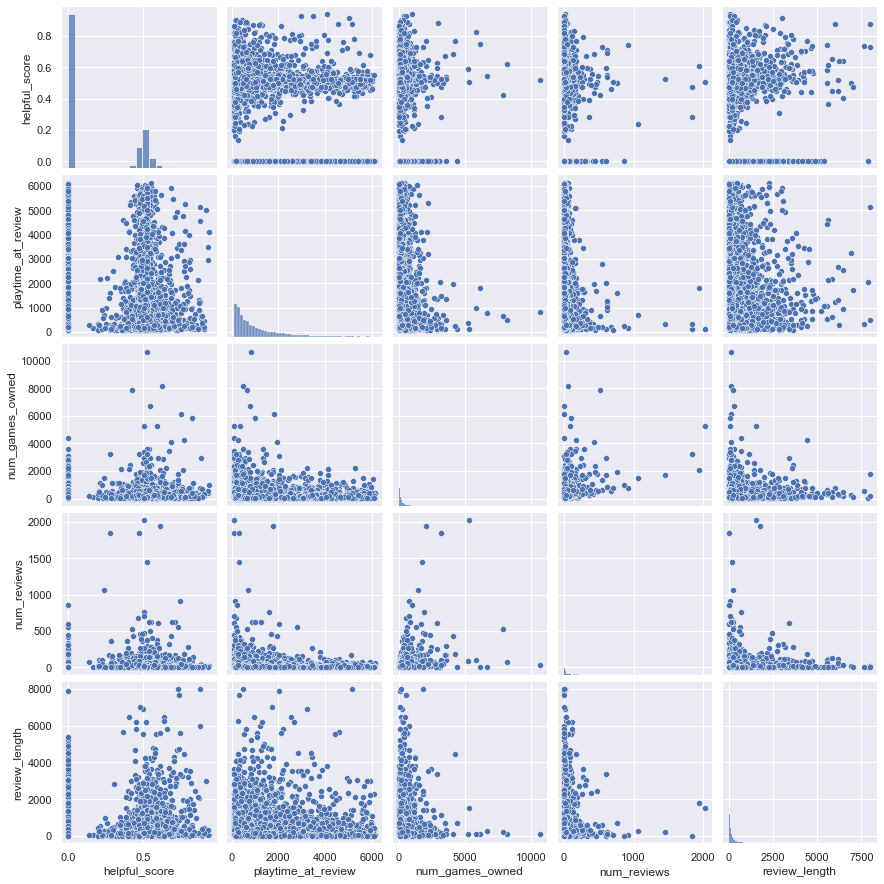

In [143]:
#pair plot
pair_data = df.sample(n=10000)[['helpful_score', 'playtime_at_review', 'num_games_owned', 'num_reviews', 'review_length']]
sns.pairplot(pair_data)

We use the pair plot to look for correlations within the data. For each of the columns, it compares one metric to another. The diagonal of the pair plot is just a histogram of the value ranges, which can be ignored. 
For helpful score, it looks to be somewhat positively correlated to review length and number of games owned. It looks like a lot of points are at the 0.0 mark, meaning they were not deemed helpful at all. 
It looks like longer reviews might mean less play time on average. 
As expected, the more games owned leads to more reviews. 


([<matplotlib.patches.Wedge at 0x7f980555dc40>,
 [Text(0.9258314554848706, 0.5940000976723543, 'Risk of Rain 2'),
  Text(-0.025016499493500113, 1.0997154971869278, 'Bloons TD 6'),
  Text(-0.8379398684405048, 0.7126407067224757, 'Raft'),
  Text(-1.0999812454804707, -0.006423362922371225, 'Beat Saber'),
  Text(-0.9013198959825299, -0.6305731084545564, 'Slay the Spire'),
  Text(-0.4415016519984516, -1.0075099459968813, "Assassin's Creed Odyssey"),
  Text(0.09277605302759034, -1.0960805645501712, 'Stick Fight: The Game'),
  Text(0.573069432253452, -0.9389310016272263, 'Sekiro™: Shadows Die Twice'),
  Text(0.9231430938573078, -0.5981695648088075, 'Resident Evil 2'),
  Text(1.0826324118510395, -0.19469735696614157, 'Ravenfield')],
 [Text(0.5049989757190202, 0.32400005327582954, '18%'),
  Text(-0.01364536336009097, 0.5998448166474151, '14%'),
  Text(-0.45705811005845715, 0.388713112757714, '12%'),
  Text(-0.5999897702620749, -0.0035036525031115766, '10%'),
  Text(-0.491629034172289, -0.343948

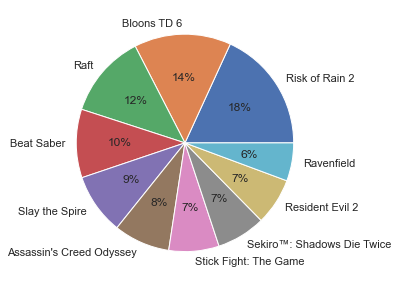

In [144]:
#Pie chart for share of top 10 most reviewed games
#get games and values for future use in box plot (grab first 10)
top_ten_games = df.groupby("appid").count().reset_index().sort_values(ascending=False, by='is_recommended')['appid'][:10].to_list()
top_ten_values = df.groupby("appid").count().reset_index().sort_values(ascending=False, by='is_recommended')['steamid'][:10].to_list()
labels = ['Risk of Rain 2', 'Bloons TD 6', 'Raft', 'Beat Saber', 'Slay the Spire', 'Assassin\'s Creed Odyssey', 'Stick Fight: The Game'
          , 'Sekiro™: Shadows Die Twice', 'Resident Evil 2', 'Ravenfield']
plt.figure(figsize=(10,5))
plt.pie(top_ten_values, labels = labels, autopct='%.0f%%')

In [145]:
#box plot for hours played of 10 most popular games
data = df.copy()
data = data[data['appid'].isin(top_ten_games)]
games = {
    632360: "Risk of Rain 2", 
    960090: "Bloons TD 6", 
    648800: "Raft", 
    620980: "Beat Saber",
    646570: "Slay the Spire",
    812140: "Assassin's Creed Odyssey",
    674940: "Stick Fight: The Game",
    814380: "Sekiro™: Shadows Die Twice",
    883710: "Resident Evil 2",
    636480: "Ravenfield", 
    613100: "House Flipper"
}

In [146]:
#create game name column for x axis
data["game_name"] = data.appid.map(lambda x: games[x])

(0.0, 15000.0)

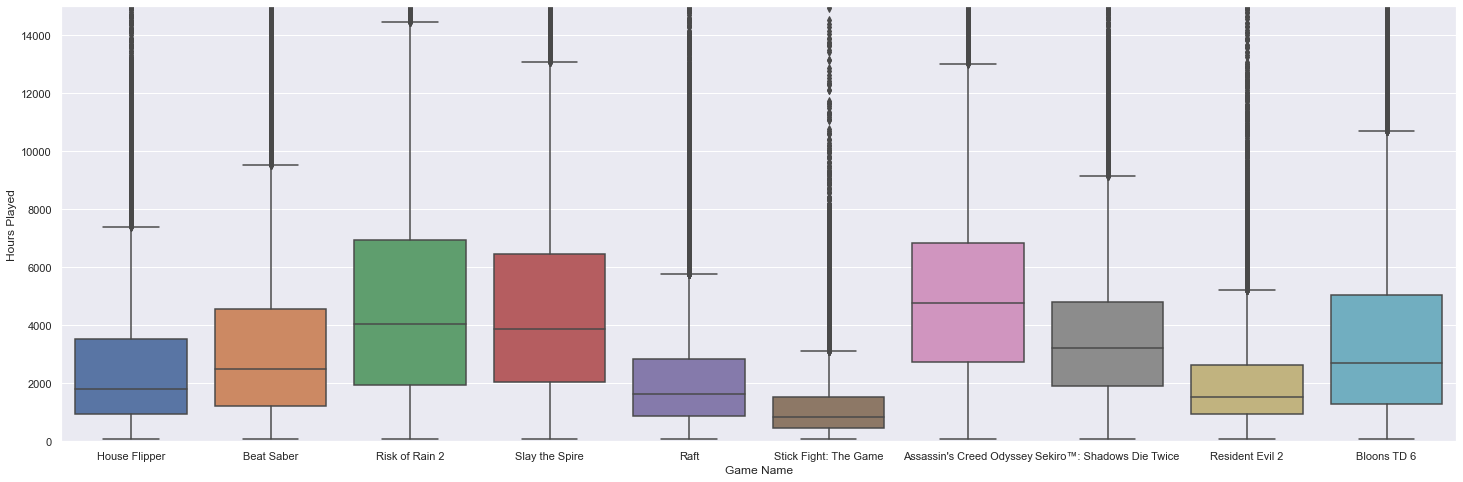

In [147]:
plt.figure(figsize=(25,8))
fig = sns.boxplot(x='game_name', y='playtime_forever', data=data)
fig.set(xlabel='Game Name', ylabel='Hours Played')
plt.ylim(0,15000)